# Importing the data

## Import Libraries

In [1]:
# import system libraries
import os
import itertools
from PIL import Image
import cv2
from matplotlib.image import imread

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold


# import Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import regularizers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

figsize = (20, 8)
fontsize = 20
lablesize = 14

2024-11-19 13:05:19.512872: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-19 13:05:20.008581: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-19 13:05:20.012731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 13:05:31.474811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
data_dir = 'Bird_Species_Dataset' 
#the code file should be in the same folder as the folder called 'Bird Species Dataset' thus this is the path to the folder containing the dataset
filepaths, image_list, label_list = [], [], []

folders = os.listdir(data_dir)

#print(folders)

for fold in folders:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
    for f in flist:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        label_list.append(fold)

print(filepaths)
print(label_list)

for file in filepaths:
    image = cv2.imread(file)
    image = img_to_array(image)
    image_list.append(image)
    
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(label_list, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

['Bird_Species_Dataset/AMERICAN GOLDFINCH/001.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/002.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/003.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/004.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/005.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/006.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/007.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/008.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/009.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/010.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/011.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/012.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/013.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/014.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/015.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/016.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/017.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/018.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/019.jpg', 'Bird_Species_Dataset/AMERICAN

In [4]:
df['labels'].value_counts()

labels
AMERICAN GOLDFINCH    143
EMPEROR PENGUIN       139
DOWNY WOODPECKER      137
FLAMINGO              132
CARMINE BEE-EATER     131
BARN OWL              129
Name: count, dtype: int64

In [5]:
np.shape(image_list)

(811, 224, 224, 3)

### Plot bird-pictures

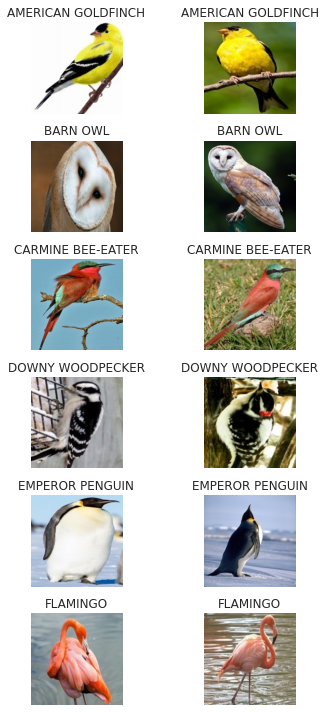

In [17]:
num_images = 2

# Get unique bird species labels
bird_species = df['labels'].unique()

# Set up the plot
plt.figure(figsize=(6, 10))

# Loop through each bird species
for idx, bird in enumerate(bird_species):
    # Filter the DataFrame to get file paths for this bird species
    bird_df = df[df['labels'] == bird].sample(num_images)  # Get a random sample of 16 images
    
    # Loop through the 16 images and plot them
    for i, file in enumerate(bird_df['filepaths'].values):
        plt.subplot(len(bird_species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(bird)
        
# Show the plot
plt.tight_layout()
plt.savefig("CNN_plots/birds.png")

### Splitting Data 

In [18]:
"""# Splitting dataset
strat = df['labels']
train_df, dummy_df = train_test_split(df, test_size=.3, shuffle=True, stratify=strat, random_state=123)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=.5, shuffle=True, stratify=strat, random_state=123)"""

# Splitting dataset
strat = df['labels']
train_df, test_df = train_test_split(df, test_size=.3, shuffle=True, stratify=strat, random_state=123)


print(f"Number of Training dataset: {len(train_df)}\nNumber of Testing dataset: {len(test_df)}")

# NOTE: stratify = strat -> equal proportions of bird-labels in each data-substet (Train/Test/Val) as original data 

Number of Training dataset: 567
Number of Testing dataset: 244


### Change input to **ImageDataGenerator** objects

In [36]:
# crobed image size
batch_size_IDG = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()


train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', 
                                       color_mode='rgb', shuffle= True, batch_size=batch_size_IDG)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size_IDG)


print(tr_gen)

Found 567 validated image filenames belonging to 6 classes.


Found 244 validated image filenames belonging to 6 classes.


### Images Structure

In [9]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

## CNN function

In [ ]:

def CNN(eta, lmbd, n_filters, n_conv, n_pool, n_neurons, act_func, optimizer, extra_dense_layers=None):
    model = Sequential([
        Conv2D(n_filters, (n_conv,n_conv), activation=act_func, padding='same', input_shape = img_shape, kernel_regularizer=regularizers.l2(lmbd)),
        MaxPooling2D((n_pool,n_pool)),

        Conv2D(n_filters*2, (n_conv,n_conv), activation=act_func, padding='same', kernel_regularizer=regularizers.l2(lmbd)),
        MaxPooling2D((n_pool*2,n_pool*2)),

        Conv2D(n_filters*4, (n_conv,n_conv), activation=act_func, padding='same', kernel_regularizer=regularizers.l2(lmbd)),
        MaxPooling2D((n_pool*4,n_pool*4)),
        #MaxPooling2D((n_pool,n_pool)),  # mark this in if too many #params
        
        Flatten(),
        Dense(n_neurons, activation=act_func, kernel_regularizer=regularizers.l2(lmbd)),
    ]) 

    # Add any additional dense layers specified in extra_dense_layers
    if extra_dense_layers:
        for i in range(extra_dense_layers):
            model.add(Dense(n_neurons, activation=act_func, kernel_regularizer=regularizers.l2(lmbd)))
        """for n_neurons in extra_dense_layers:
            model.add(Dense(n_neurons, activation=act_func, kernel_regularizer=regularizers.l2(lmbd)))"""
        
    
    # Add the final output layer for classification
    model.add(Dense(class_count, activation='softmax'))
    
    
    #model.compile(Adam(learning_rate = eta), loss = 'categorical_crossentropy', metrics=['acc'])
    model.compile(optimizer(learning_rate = eta), loss = 'categorical_crossentropy', metrics=['acc'])
    # NOTES: 
    # INFO: tf.keras.Sequential   -> look at: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

    # compile(...,  loss = 'categorical_crossentropy')  -> Computes the crossentropy loss between the labels and predictions.
    
    return model


early_stopping = EarlyStopping(
    patience=100,
    min_delta=0,
    mode=min,
    monitor='val_loss',
    verbose=0,
    restore_best_weights=True,
    baseline=None
)



### Comparison $\lambda$ vs. $\eta$ with CNN model 

In [ ]:
# Set seed for reproducibility
seed = 2024
tf.keras.backend.clear_session()     # Clear any previous model session
tf.keras.utils.set_random_seed(seed) # must include for reproducibility 


# ------------------- K-Fold Cross Validation
n_splits = 5  # Number of k-folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

# ------------------ Setting up parameters

# ---- Fixed Parameters trought project----
n_filters = 6
n_conv = 3
n_pool = 2
n_neurons = 50
epochs = 100 # Final training with epochs = 1000
# -----------------------------------------

batch_size = 10
act_func = 'relu'
optimizer = tf.keras.optimizers.Adam 
# Have implemented other optimizer for futere work
# if want to test with different otimizers, ex Adamax etc..


In [ ]:

# Defining parameter-space to search for optimal fit
max_lmbd = -4
max_eta = -4
N_lmbd = abs(max_lmbd) + 1
N_eta = abs(max_eta) + 1

lmbd_list = np.logspace(max_lmbd, 0, N_lmbd)
lmbd_list[0] = 0 # setting first elemenent to include no L2-penalty
eta_list = np.logspace(max_eta, 0, N_eta)

print("lmbd = ", lmbd_list)
print("eta  = ", eta_list)


CNN_model_list = []
fit_list       = []
for lmbd in lmbd_list:
    for eta in eta_list:
        fold = 0
        fit  = []
        for train_idx, val_idx in kf.split(train_df): # performing K-Fold
            # Split the data
            tr_fold, v_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]

            ID_tr_gen = ImageDataGenerator()
            ID_v_gen  =  ImageDataGenerator()
            train_fold = ID_tr_gen.flow_from_dataframe(tr_fold, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle= True, batch_size=batch_size_IDG)
            val_fold   = ID_v_gen.flow_from_dataframe(v_fold, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle= True, batch_size=batch_size_IDG)

            
            # Initialize a new model for each fold
            CNN_model = CNN(eta, lmbd, n_filters, n_conv, n_pool, n_neurons, act_func, optimizer)
            #print("------------------------- SUMMARY --------------------------")
            #CNN_model.summary()

            # Train on current fold
            print(f'\nFold {fold + 1} - lmbd = {lmbd}, eta = {eta}\n')
            fit_fold = CNN_model.fit(x= train_fold, epochs=epochs, batch_size=batch_size, validation_data=val_fold, verbose=0, callbacks=[early_stopping])
            
            fit.append(fit_fold)
            fold += 1
            tf.keras.backend.clear_session() 

        # Save results
        fit_list.append([fit, lmbd, eta])

lmbd =  [0.01]
eta  =  [0.001]
Found 453 validated image filenames belonging to 6 classes.


Found 114 validated image filenames belonging to 6 classes.

Fold 1 - lmbd = 0.01, eta = 0.001

Epoch 1/10
57/57 [==============================] - 7s 97ms/step - loss: 27.2216 - acc: 0.3819 - val_loss: 2.1183 - val_acc: 0.6404
Epoch 2/10
57/57 [==============================] - 5s 81ms/step - loss: 1.5431 - acc: 0.8587 - val_loss: 1.7660 - val_acc: 0.7193
Epoch 3/10
57/57 [==============================] - 4s 76ms/step - loss: 1.1701 - acc: 0.9558 - val_loss: 2.1335 - val_acc: 0.6754
Epoch 4/10
57/57 [==============================] - 4s 77ms/step - loss: 1.1384 - acc: 0.9647 - val_loss: 1.7680 - val_acc: 0.7281
Epoch 5/10
57/57 [==============================] - 4s 74ms/step - loss: 0.9561 - acc: 1.0000 - val_loss: 1.7244 - val_acc: 0.8070
Epoch 6/10
57/57 [==============================] - 5s 81ms/step - loss: 0.9030 - acc: 1.0000 - val_loss: 1.7095 - val_acc: 0.7982
Epoch 7/10
57/57 [==============================] - 4s 75ms/step - loss: 0.8597 - acc: 1.0000 - val_loss: 1.6857 - va

KeyboardInterrupt: 

### Performance Scores: $\lambda$ vs. $\eta$

In [20]:
def plot_accuracy_evoluton(fit_list, string1, string2, png_name):
    plt.figure(figsize=figsize)
    plt.style.use('fivethirtyeight')

    # Loop through fit_list to plot each fit's validation accuracy
    for fit, var1, var2 in fit_list: 

        val_acc = np.mean([f.history['val_acc'] for f in fit], axis=0) # calculating mean val_acc for all folds
        if val_acc[-1] < 0.6: # not plot if last accuracy < 0.6
                continue  
        
        Epochs = [i+1 for i in range(len(val_acc))]

        if isinstance(var1, str):
            if isinstance(var2, str):
                plt.plot(Epochs, val_acc, label= f'{string1} = {var1}, {string2} = {var2}')
            else: 
                plt.plot(Epochs, val_acc, label= f'{string1} = {var1}, {string2} = {var2:g}')
        elif isinstance(var2, str):
            plt.plot(Epochs, val_acc, label= f'{string1} = {var1:3g}, {string2} = {var2}')
        elif isinstance(var2, list):
            plt.plot(Epochs, val_acc, label= f'{string1} = {var1:3g}, {string2} = {var2}')
        else:
            plt.plot(Epochs, val_acc, label= f'{string1} = {var1:3g}, {string2} = {var2}')


    plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Cutoff') # cutoff, only include val_acc[-1] > cutoff = 0.5
    plt.suptitle(rf'CNN      -      Validation Accuracy   -   {string1}  vs. {string2}', fontsize=fontsize)
    plt.title(r"", fontsize=fontsize-5)
    plt.xlabel('Epochs', fontsize=lablesize)
    plt.ylabel('Accuracy', fontsize=lablesize)
    plt.legend(loc='upper left')

    plt.tight_layout
    plt.savefig("CNN_plots/" + png_name + ".png")



def plot_heatmap(fit_list, var1, var2, string1, string2, png_name):


    val_acc = [] # list with all accuracy scores for validation set    
    for fit, _, _ in fit_list:
        v_acc = np.mean([f.history['val_acc'] for f in fit], axis=0) # calculating mean val_acc for all folds
        val_acc.append(v_acc[-1])

    val_acc_heatmap = np.array(val_acc).reshape( (len(var1), len(var2)) )

    # Find index for maximum val_acc
    index_max_val_acc = np.argmax(val_acc_heatmap)
    index_max_2d = np.unravel_index(index_max_val_acc, val_acc_heatmap.shape)

    # Create heatmap
    plt.figure(figsize=(8, 6))
    plt.style.use('fivethirtyeight')

    sns.heatmap(val_acc_heatmap, annot=True, cmap="coolwarm", xticklabels=var2, yticklabels=var1)
    # Get the row and column to highlight highest accuracy
    # Draw lines around the specified cell
    row, col = index_max_2d
    plt.vlines(col, row, row + 1, color='yellow', linewidth=2)  # Left vertical
    plt.vlines(col + 1, row, row + 1, color='yellow', linewidth=2)  # Right vertical
    plt.hlines(row, col, col + 1, color='yellow', linewidth=2)  # Bottom horizontal
    plt.hlines(row + 1, col, col + 1, color='yellow', linewidth=2)  # Top horizontal

    plt.suptitle(r'CNN      -      Validation Accuracy', fontsize=fontsize)
    plt.title(rf"{string1}  vs. {string2}", fontsize=fontsize)
    plt.xlabel(rf"{string2}", fontsize = lablesize)
    plt.ylabel(rf"{string1}", fontsize = lablesize)

    plt.savefig("CNN_plots/" + png_name + ".png")

    return index_max_val_acc, index_max_2d
    
    

--------- Optimal Fit (according to Validation Accuracy)--------------
Accuracy(lmbd = 0.0, eta = 0.1) = 0.173


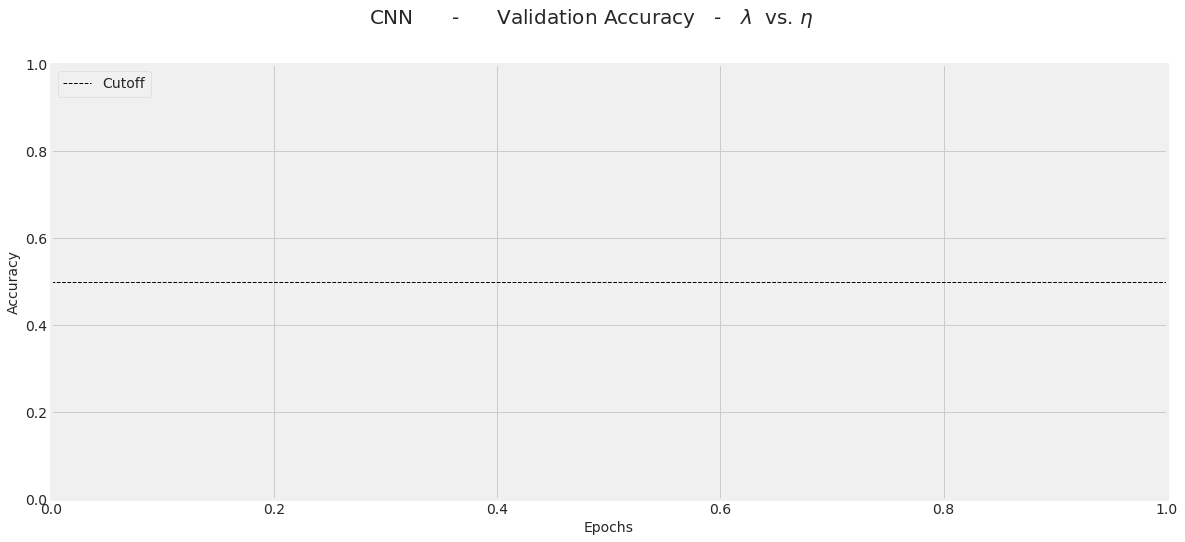

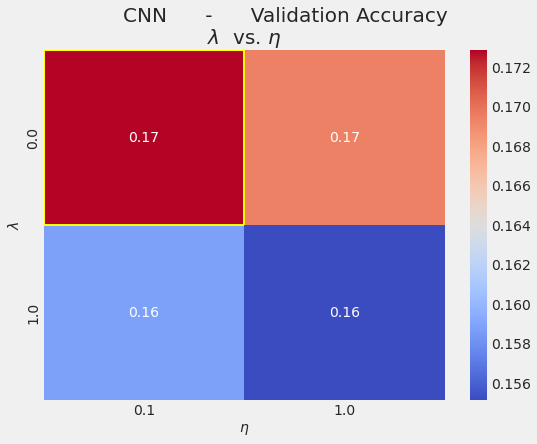

In [ ]:

string1 = '$\lambda$'
string2 = '$\eta$'
png_name = 'val_acc_' + 'lambda' + "_" + 'eta'
plot_accuracy_evoluton(fit_list, string1, string2, png_name)


var1 = lmbd_list
var2 = eta_list
png_name = 'heatmap_val_acc' + 'lambda' + "_" + 'eta'
index_max_val_acc, index_max_2d =  plot_heatmap(fit_list, var1, var2, string1, string2, png_name)





# ---------------------------- Selecting optimal fit for lmbd vs. eta (according to Validation Accuracy)
# Save parameters for future use 
fit, lmbd, eta = fit_list[index_max_val_acc]
 
val_acc_optimal = np.mean([f.history['val_acc'] for f in fit], axis=0)[-1] # calculating mean val_acc for all folds

print("--------- Optimal Fit (according to Validation Accuracy)--------------")
print(f"Accuracy(lmbd = {lmbd}, eta = {eta}) = {val_acc_optimal:.3f}")


### Comparison Activation Functions vs. Batch Size (M)  with CNN model 

In [ ]:
tf.keras.utils.set_random_seed(seed) # must include for reproducibility 



# Defining parameter-space to search for optimal fit
batch_size_list = np.linspace(5,50,10)   # forlag1 (5, 100, 20) forslag2 (10,100,10)
act_func_list = ['relu', 'leaky_relu'] 
# act_func-string must match tf.keras.activations found at https://www.tensorflow.org/api_docs/python/tf/keras/activations


print("batch_size_list = ", batch_size_list)
print("act_func_list  = ", act_func_list)



CNN_model_list = []
fit_list       = []
for batch_size in batch_size_list:
    for act_func in act_func_list:
        fold = 0
        fit  = []
        for train_idx, val_idx in kf.split(train_df): # performing K-Fold
            # Split the data
            tr_fold, v_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]

            ID_tr_gen = ImageDataGenerator()
            ID_v_gen  =  ImageDataGenerator()
            train_fold = ID_tr_gen.flow_from_dataframe(tr_fold, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle= True, batch_size=batch_size_IDG)
            val_fold   = ID_v_gen.flow_from_dataframe(v_fold, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle= True, batch_size=batch_size_IDG)

            
            # Initialize a new model for each fold
            CNN_model = CNN(eta, lmbd, n_filters, n_conv, n_pool, n_neurons, act_func, optimizer)
            #print("------------------------- SUMMARY --------------------------")
            #CNN_model.summary()

            # Train on current fold
            print(f'\nFold {fold + 1} - batch_size = {batch_size}, act_func = {act_func} \n\n')
            fit_fold = CNN_model.fit(x= train_fold, epochs=epochs, batch_size=batch_size, validation_data=val_fold, verbose=0, callbacks=[early_stopping])
            
            fit.append(fit_fold)
            fold += 1
            tf.keras.backend.clear_session() 

        # Save results
        fit_list.append([fit, batch_size, act_func])
        

batch_size_list =  [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]
act_func_list  =  ['relu', 'leaky_relu']
Found 453 validated image filenames belonging to 6 classes.
Found 114 validated image filenames belonging to 6 classes.

Fold 1 - batch_size = 5.0, act_func = relu 


Found 453 validated image filenames belonging to 6 classes.
Found 114 validated image filenames belonging to 6 classes.

Fold 2 - batch_size = 5.0, act_func = relu 


Found 454 validated image filenames belonging to 6 classes.
Found 113 validated image filenames belonging to 6 classes.

Fold 3 - batch_size = 5.0, act_func = relu 


Found 454 validated image filenames belonging to 6 classes.
Found 113 validated image filenames belonging to 6 classes.

Fold 4 - batch_size = 5.0, act_func = relu 


Found 454 validated image filenames belonging to 6 classes.
Found 113 validated image filenames belonging to 6 classes.

Fold 5 - batch_size = 5.0, act_func = relu 


Found 453 validated image filenames belonging to 6 classes.
Fou

2024-11-14 22:16:14.144475: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 232 bytes spill stores, 228 bytes spill loads



Found 454 validated image filenames belonging to 6 classes.
Found 113 validated image filenames belonging to 6 classes.

Fold 4 - batch_size = 5.0, act_func = leaky_relu 


Found 454 validated image filenames belonging to 6 classes.
Found 113 validated image filenames belonging to 6 classes.

Fold 5 - batch_size = 5.0, act_func = leaky_relu 


Found 453 validated image filenames belonging to 6 classes.
Found 114 validated image filenames belonging to 6 classes.

Fold 1 - batch_size = 10.0, act_func = relu 


Found 453 validated image filenames belonging to 6 classes.
Found 114 validated image filenames belonging to 6 classes.

Fold 2 - batch_size = 10.0, act_func = relu 


Found 454 validated image filenames belonging to 6 classes.
Found 113 validated image filenames belonging to 6 classes.

Fold 3 - batch_size = 10.0, act_func = relu 


Found 454 validated image filenames belonging to 6 classes.
Found 113 validated image filenames belonging to 6 classes.

Fold 4 - batch_size = 10.0, a

2024-11-14 22:16:46.720038: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_exponential_fusion', 80 bytes spill stores, 80 bytes spill loads



Found 454 validated image filenames belonging to 6 classes.
Found 113 validated image filenames belonging to 6 classes.

Fold 5 - batch_size = 10.0, act_func = relu 


Found 453 validated image filenames belonging to 6 classes.
Found 114 validated image filenames belonging to 6 classes.

Fold 1 - batch_size = 10.0, act_func = leaky_relu 


Found 453 validated image filenames belonging to 6 classes.
Found 114 validated image filenames belonging to 6 classes.

Fold 2 - batch_size = 10.0, act_func = leaky_relu 


Found 454 validated image filenames belonging to 6 classes.
Found 113 validated image filenames belonging to 6 classes.

Fold 3 - batch_size = 10.0, act_func = leaky_relu 


Found 454 validated image filenames belonging to 6 classes.
Found 113 validated image filenames belonging to 6 classes.

Fold 4 - batch_size = 10.0, act_func = leaky_relu 


Found 454 validated image filenames belonging to 6 classes.
Found 113 validated image filenames belonging to 6 classes.

Fold 5 - batch_

### Performance Scores: Activation Functions vs. Batch Size (M)

--------- Optimal Fit (according to Validation Accuracy)--------------
Accuracy(batch_size = 40.0, act_func = leaky_relu) = 0.773


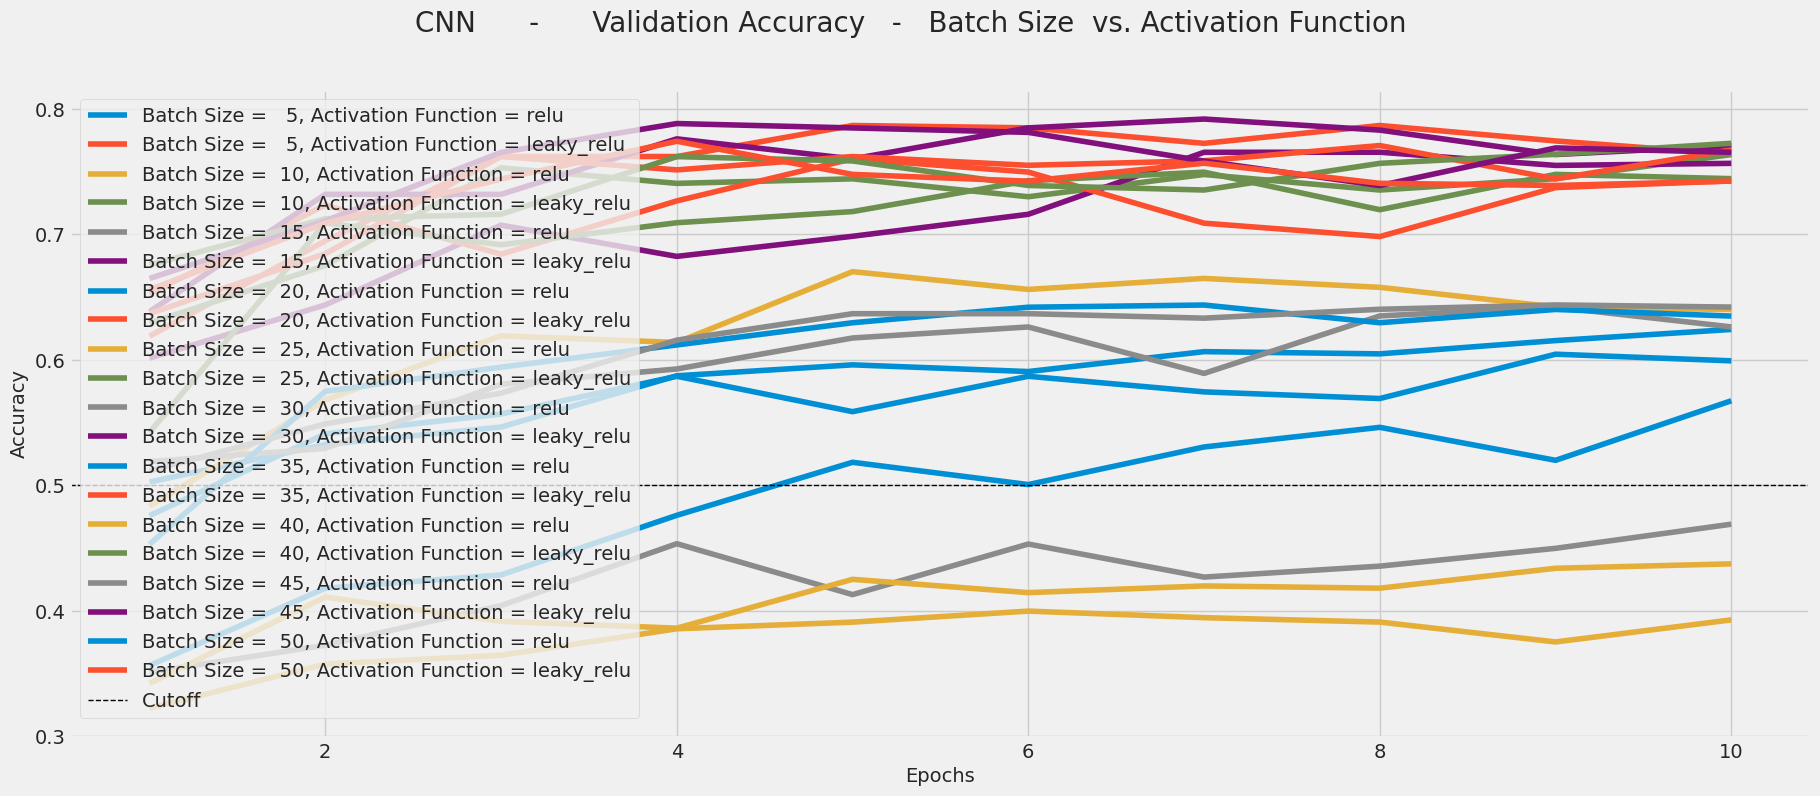

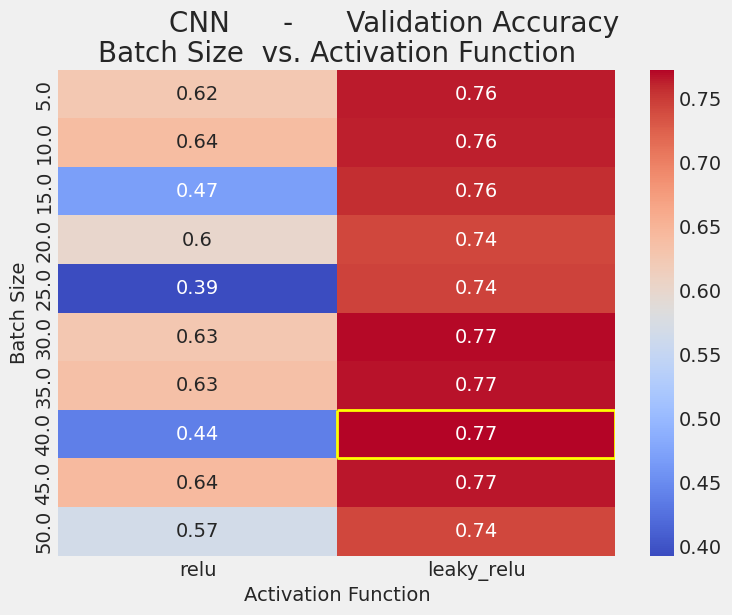

In [16]:
string1 = 'Batch Size'
string2 = 'Activation Function'
png_name = 'val_acc_' + string1 + "_" + string2
plot_accuracy_evoluton(fit_list, string1, string2, png_name)


var1 = batch_size_list
var2 = act_func_list
png_name = 'heatmap_val_acc' + string1 + "_" + string2
index_max_val_acc, index_max_2d =  plot_heatmap(fit_list, var1, var2, string1, string2, png_name)




# ---------------------------- Selecting optimal fit for lmbd vs. eta (according to Validation Accuracy)
# Save parameters for future use 
fit, batch_size, act_func = fit_list[index_max_val_acc] 

val_acc_optimal = np.mean([f.history['val_acc'] for f in fit], axis=0)[-1] # calculating mean val_acc for all folds

print("--------- Optimal Fit (according to Validation Accuracy)--------------")
print(f"Accuracy(batch_size = {batch_size}, act_func = {act_func}) = {val_acc_optimal:.3f}")


In [ ]:
tf.keras.utils.set_random_seed(seed) # must include for reproducibility 

# Defining parameter-space to search for optimal fit
n_neurons_list = np.linspace(20,70,6)
extra_dense_layer_list = [None, 1, 2]
# had to limit n_neurons_list from 10 elements to 7 because of memory issues
# had to limit extra_dense_layer_list from 4 elements to 3 because of memory issues 

batch_size_IDG = 8 # lower batch_size for ImageDataGenerator because of memory issues



print("n_neurons_list = ", n_neurons_list)
print("extra_dense_layer_list  = ", extra_dense_layer_list)


CNN_model_list = []
fit_list       = []
for n_neurons in n_neurons_list:
    for extra_dense_layer in extra_dense_layer_list:
        fold = 0
        fit  = []
        for train_idx, val_idx in kf.split(train_df): # performing K-Fold
            # Split the data
            tr_fold, v_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]

            ID_tr_gen = ImageDataGenerator()
            ID_v_gen  =  ImageDataGenerator()
            train_fold = ID_tr_gen.flow_from_dataframe(tr_fold, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle= True, batch_size=batch_size_IDG)
            val_fold   = ID_v_gen.flow_from_dataframe(v_fold, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle= True, batch_size=batch_size_IDG)

            
            # Initialize a new model for each fold
            CNN_model = CNN(eta, lmbd, n_filters, n_conv, n_pool, int(n_neurons), act_func, optimizer, extra_dense_layer)
            #print("------------------------- SUMMARY --------------------------")
            #CNN_model.summary()

            # Train on current fold
            print(f'\nFold {fold + 1} - n_neurons = {n_neurons}, extra_dense_layer = {extra_dense_layer}\n')
            fit_fold = CNN_model.fit(x= train_fold, epochs=epochs, batch_size=batch_size, validation_data=val_fold, verbose=0, callbacks=[early_stopping])
            
            fit.append(fit_fold)
            fold += 1
            tf.keras.backend.clear_session() 

        # Save results
        fit_list.append([fit, n_neurons, extra_dense_layer])
              

n_neurons_list =  [10]
extra_dense_layer_list  =  [1, 2]
Found 453 validated image filenames belonging to 6 classes.
Found 114 validated image filenames belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 12)      660       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 12)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (

--------- Optimal Fit (according to Validation Accuracy)--------------
Accuracy(n_neurons = 10, extra_dense_layer = 1) = 0.792


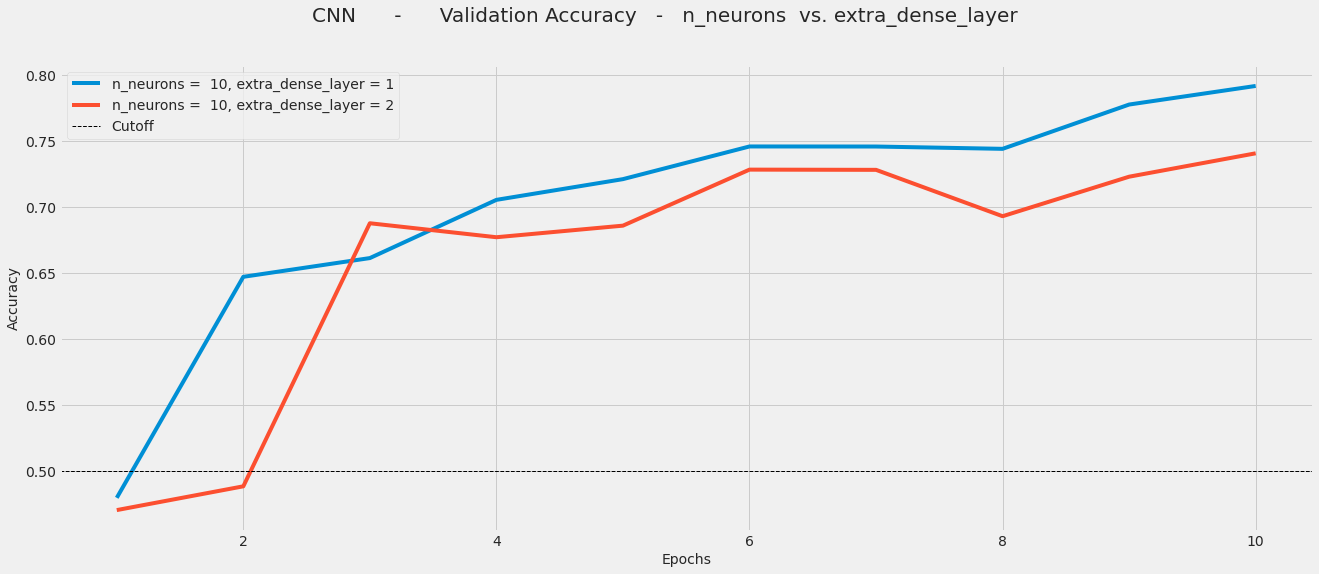

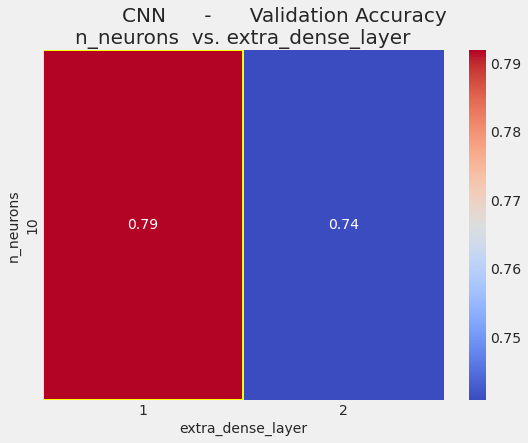

In [35]:
string1 = 'n_neurons'
string2 = 'extra_dense_layer'
png_name = 'val_acc_' + string1 + "_" + string2
plot_accuracy_evoluton(fit_list, string1, string2, png_name)

var1 = n_neurons_list
var2 = extra_dense_layer_list
png_name = 'heatmap_val_acc' + string1 + "_" + string2
index_max_val_acc, index_max_2d =  plot_heatmap(fit_list, var1, var2, string1, string2, png_name)




# ---------------------------- Selecting optimal fit for lmbd vs. eta (according to Validation Accuracy)
# Save parameters for future use 
fit, n_neurons, extra_dense_layer = fit_list[index_max_val_acc] 

val_acc_optimal = np.mean([f.history['val_acc'] for f in fit], axis=0)[-1] # calculating mean val_acc for all folds

print("--------- Optimal Fit (according to Validation Accuracy)--------------")
print(f"Accuracy(n_neurons = {n_neurons}, extra_dense_layer = {extra_dense_layer}) = {val_acc_optimal:.3f}")


# Running Final Model


In [ ]:
# ---------------- Making Final Model
epochs = 100
n_neurons = 20

CNN_model = CNN(eta, lmbd, n_filters, n_conv, n_pool, int(n_neurons), act_func, optimizer, extra_dense_layer)
print("------------------------- SUMMARY --------------------------")
CNN_model.summary()

fit = CNN_model.fit(x= train_gen, epochs=epochs, batch_size=batch_size, validation_data=test_gen, verbose=1, callbacks=[early_stopping])

# Define needed variables
tr_acc = fit.history['acc']
tr_loss = fit.history['loss']
val_acc = fit.history['val_acc']
val_loss = fit.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch = {str(index_loss + 1)}'
acc_label = f'best epoch = {str(index_acc + 1)}'

------------------------- SUMMARY --------------------------
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 224, 224, 6)       168       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 112, 112, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 112, 112, 12)      660       
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 28, 28, 12)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 28, 28, 24)        2616      
                                                          

## Performance Scores 
### Optimal $\lambda$, $\eta$, (should be Activation Functions, Batch Size (M), # Hidden Layers, # Hidden Nodes) 

#### Training & Validation - Cross Entropy Loss 

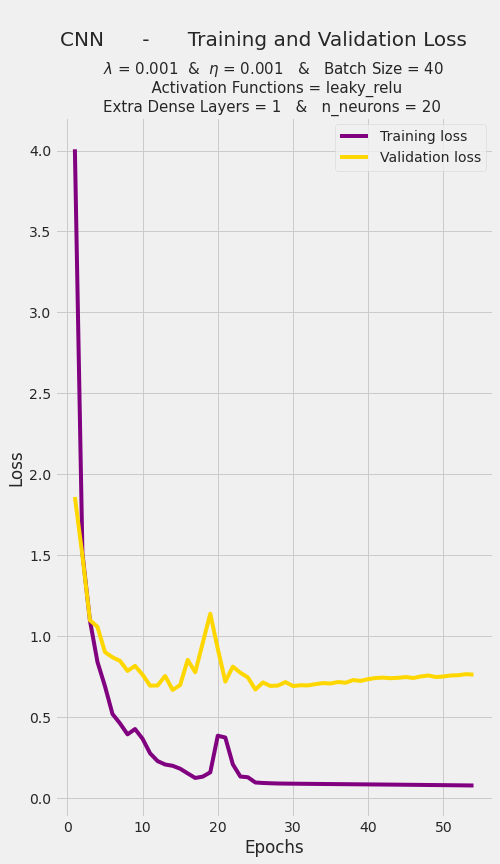

In [107]:
plt.figure(figsize= (7, 12))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'gold', label= 'Validation loss')

parameter_string = rf"$\lambda$ = {lmbd}  &  $\eta$ = {eta}   &   Batch Size = {batch_size}   &   Activation Functions = {act_func}   &   Extra Dense Layers = {extra_dense_layer}   &   n_neurons = {n_neurons} "
parameter_string_wrapped = "\n \n \n" + rf"$\lambda$ = {lmbd}  &  $\eta$ = {eta}   &   Batch Size = {batch_size} " + "\n" + f"  Activation Functions = {act_func} " + "\n" + f"Extra Dense Layers = {extra_dense_layer}   &   n_neurons = {n_neurons} "
#plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.suptitle('CNN      -      Training and Validation Loss \n' , fontsize=fontsize)
plt.title(parameter_string_wrapped, fontsize=fontsize-5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout
plt.savefig("CNN_plots/train_val_loss.png")

#### Training & Validation - Accuracy

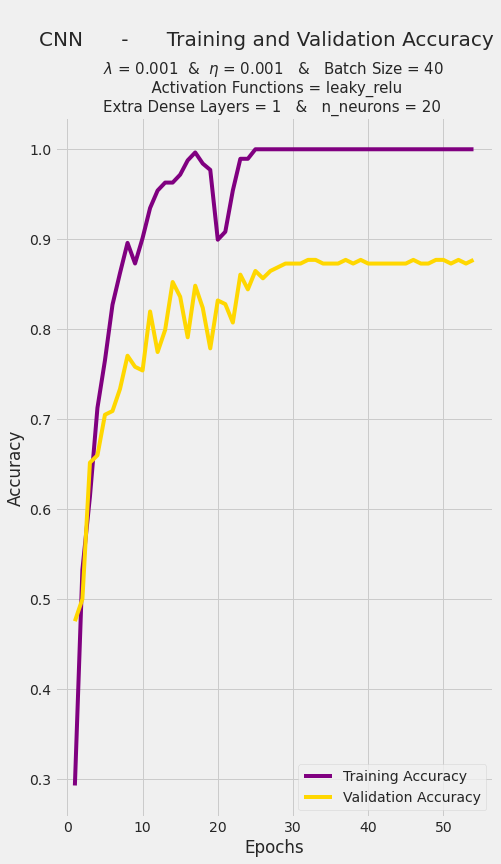

In [108]:
plt.figure(figsize= (7, 12))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'gold', label= 'Validation Accuracy')
#plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.suptitle('CNN      -      Training and Validation Accuracy', fontsize=fontsize)
plt.title(parameter_string_wrapped, fontsize=fontsize-5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.savefig("CNN_plots/train_val_acc.png")

### Make Predictions

31/31 [==============================] - 1s 27ms/step


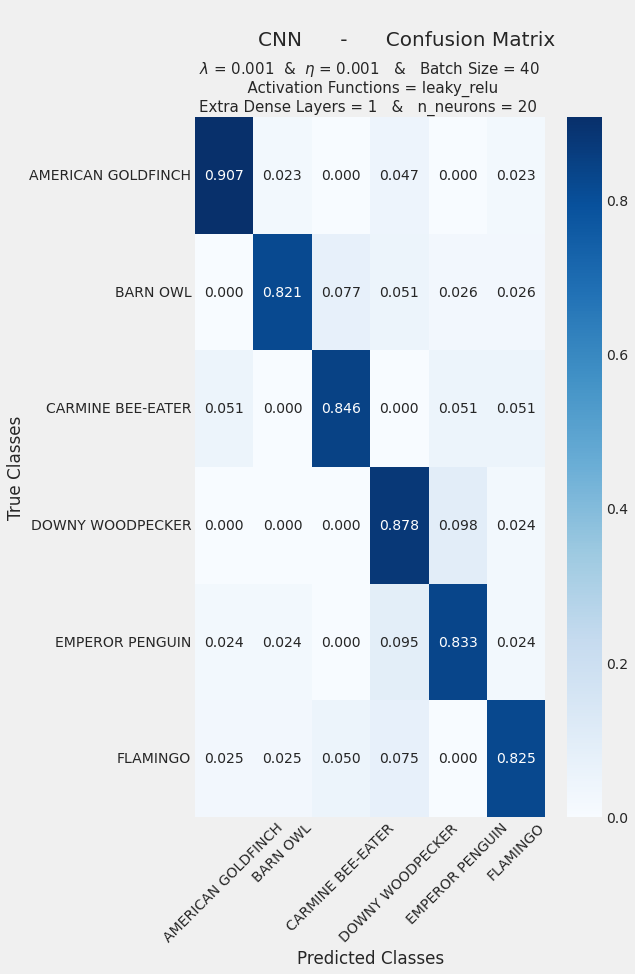

In [111]:
# Make Predictions
preds  = CNN_model.predict(test_gen) # Probabilities 6 labes   shape (122, 6)

y_pred = np.argmax(preds, axis=1)    # Most probable label     shape (122,)


# -------------------------.-- Plot Confusion matrix --------------------------------------
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred, normalize='true') 
# normalize = 'true' -> get respective accuracy scores  
# sum each row = 1 

# Create a heat map
plt.figure(figsize= (7, 12))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, fmt='.3f') #,  fmt='d')


plt.suptitle('CNN      -      Confusion Matrix', fontsize=fontsize)
plt.title(parameter_string_wrapped, fontsize=fontsize-5)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')

# Modify the rotation of axis labels
plt.xticks(rotation=45)  # Rotation of x-axis labels
plt.yticks(rotation=0)   # Rotation of y-axis labels

plt.savefig("CNN_plots/confusion_matrix.png")
plt.show()




### Final Evaluation Model

In [82]:
train_score = CNN_model.evaluate(train_gen, verbose=1)
test_score  = CNN_model.evaluate(test_gen, verbose=1)
# .evaluate gives list of score ["Cross_Entropy_Loss", "Accuracy"]

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


31/31 [==============================] - 1s 20ms/step - loss: 0.6674 - acc: 0.8525
Train Loss:  0.1395755559206009
Train Accuracy:  0.9876543283462524
--------------------
Test Loss:  0.667386531829834
Test Accuracy:  0.8524590134620667
